<a href="https://colab.research.google.com/github/sejin-sim/Object_detection/blob/main/Faster_R-CNN/Faster_R_CNN_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- https://learnopencv.com/faster-r-cnn-object-detection-with-pytorch/

### 3.1. Input and Output   
The pretrained Faster R-CNN ResNet-50 model that we are going to use expects the input image tensor to be in the form [n, c, h, w] and have a min size of 800px, where:

사전 학습된 Faster R-CNN ResNet-50 모델은 [n, c, h, w] 형식으로 인풋을 받고, 사이즈는 최소 800이다.

- "n" is the number of images : 이미지의 갯수
- "c" is the number of channels , for RGB images its 3 : 채널의 갯수 ex) RGB 3
- "h" is the height of the image : 높이
- "w" is the width of the image : 너비

        # numpy image: H x W x C
        # torch image: C X H X W
        
The model will return 

- Bounding boxes [x0, y0, x1, y1] all the predicted classes of shape (N,4) where N is the number of classes predicted by the model to be present in the image.

- 경계 상자 [x0, y0, x1, y1] 모든 클래스 예측의 형태는 (N, 4). N은 현재 이미지에서의 예측 클래스 갯수이다.

- Labels of all the predicted classes.
- Scores of each of the predicted label.

### 3.2. Pretrained Model

In [ ]:
from PIL import Image
import numpy as np
import torch
import torchvision
from torchvision import transforms as T
import matplotlib.pylab as plt
import cv2

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True) # pretrained=True 인자를 넘김
#  torchvision.model : 미리 정의되어 있는 모델들 사용. 구조 &  pretrained weights를 가져올 수도 있다.

model.eval()  # 모델 테스트 시
# model.train()과 model.eval()은 모델이 학습 모드인지, 테스트 모드인지를 정하는 것이다. 
# dropout이나 batchnorm이 있는 모델의 경우 학습할 때와 테스트할 때 모델이 달라지기 때문에 세팅하는 것이다(또한 필수이다). 

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [ ]:
# Define the class names given by PyTorch’s official docs

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

We can see some N/A’s in the list, as a few classes were removed in the later papers. We will go with the list given by PyTorch.

우리는 PyTorch가 준 리스트로 하겠습니다.

### 3.3. Prediction of the model
Let’s define a function to get the image path and get the prediction of the image by the model.

영상 경로를 가져오고 모델에 의한 이미지 예측을 얻는 함수를 정의하겠습니다.

In [ ]:
def get_prediction(img_path, threshold):
  img = Image.open(img_path)                  # Load the image
  # img = PIL object image mode=RGB size=2000x1333

  transform = T.Compose([T.ToTensor()])      
  # compose : 변환 함수들을 하나로 조합하는 함수. ToTensor : torch.Tensor로 변환시킨다.

  img = transform(img)                        # compose 함수를 dataloader에 넘기면 이미지 변환 작업이 간단하게 완료된다.
  # img = torch.Size([3, 1333, 2000])

  pred = model([img])                         # Pass the image to the model : 이미지를 모델에 넘긴다. 
  # pred = "boxes" & "labels" & "score"         
  
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
  # label 값에 맞춰 카테고리 이름을 pred_class 안에 넣어주고, tensor to numpy

  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
  # box 값을 pred_boxes 안에 [(0, 1), (2, 3)] 형식으로 넣어주고, detach() 복사하여 tensor to numpy

  pred_score = list(pred[0]['scores'].detach().numpy())
  # score 값을 pred_score 안에 넣어주고, detach() 복사하여 tensor to numpy

  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
  # 임계 값보다 큰 pre_score 중 제일 큰 score index pre_t에 저장한다.
  # ex) [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] 중 12

  pred_boxes = pred_boxes[:pred_t+1 ]
  # 제일 큰 socre의 박스까지의 값

  pred_class = pred_class[:pred_t+1]
  # 제일 큰 socre의 클래스까지의 값

  return pred_boxes, pred_class

- Image is obtained from the image path

Image는 이미지 경로에서 얻어진다.

- The image is converted to image tensor using PyTorch’s Transforms

PyTorch의 Transforms를 사용하여 영상이 영상 텐서로 변환됩니다.

- The image is passed through the model to get the predictions

이미지를 모델을 통해 전달하여 예측을 얻는다.

-Class, box coordinates are obtained, but only prediction score > threshold are chosen

- 클래스, 박스 좌표는 구하지만 예측 점수 > 임계값만 선택됨

### 3.4. Pipeline for Object Detection
Next we will define a pipeline to get the image path and get the output image.

다음에는 이미지 경로를 가져오고 출력 이미지를 가져올 파이프라인을 정의합니다.

In [ ]:
def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):

  boxes, pred_cls = get_prediction(img_path, threshold) # Get predictions

  img = cv2.imread(img_path) # Read image with cv2 : 오픈 cv로 이미지 읽기

  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # BGR to RGB
  # cv2는 default가 BGR. BGR VS RGB = 순서 차이

  for i in range(len(boxes)): # 박스의 개수 만큼 반복한다. ex) 13개
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    # rectangle = 시긱형 그리기 cv2.rectangle(img, start, end, color, thickness=선의 두께)
   
    cv2.putText(img, pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
    # putText = 텍스트 추가 cv2.putText(img, text, org=문자열이 표시될 위치, font, fontSacle, color)

  plt.figure(figsize=(20,30)) # display the output image
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

- prediction is obtained from get_prediction method
- for each prediction, bounding box is drawn and text is written
with opencv
- the final image is displayed

### 3.5. Inference : 추론
Now lets use the API pipleine which we built to detect object in some images. The pretrained Model takes around 8 seconds for inference in CPU and 0.15 second in NVIDIA GTX 1080 Ti GPU.

이제 일부 이미지에서 객체를 감지하기 위해 구축한 API pipleine을 사용해 보겠습니다. 사전 훈련된 모델은 CPU에서 추론하는 데 약 8초, NVIDIA GTX 1080 Ti GPU에서 0.15초가 소요된다.

Example 3.5.1

Download an image for inference

In [ ]:
!wget https://www.wsha.org/wp-content/uploads/banner-diverse-group-of-people-2.jpg -O people.jpg

--2021-01-20 13:50:42--  https://www.wsha.org/wp-content/uploads/banner-diverse-group-of-people-2.jpg
Resolving www.wsha.org (www.wsha.org)... 104.198.7.33
Connecting to www.wsha.org (www.wsha.org)|104.198.7.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1923610 (1.8M) [image/jpeg]
Saving to: ‘people.jpg’

people.jpg          100%[===================>]   1.83M  --.-KB/s    in 0.008s  

2021-01-20 13:50:42 (228 MB/s) - ‘people.jpg’ saved [1923610/1923610]



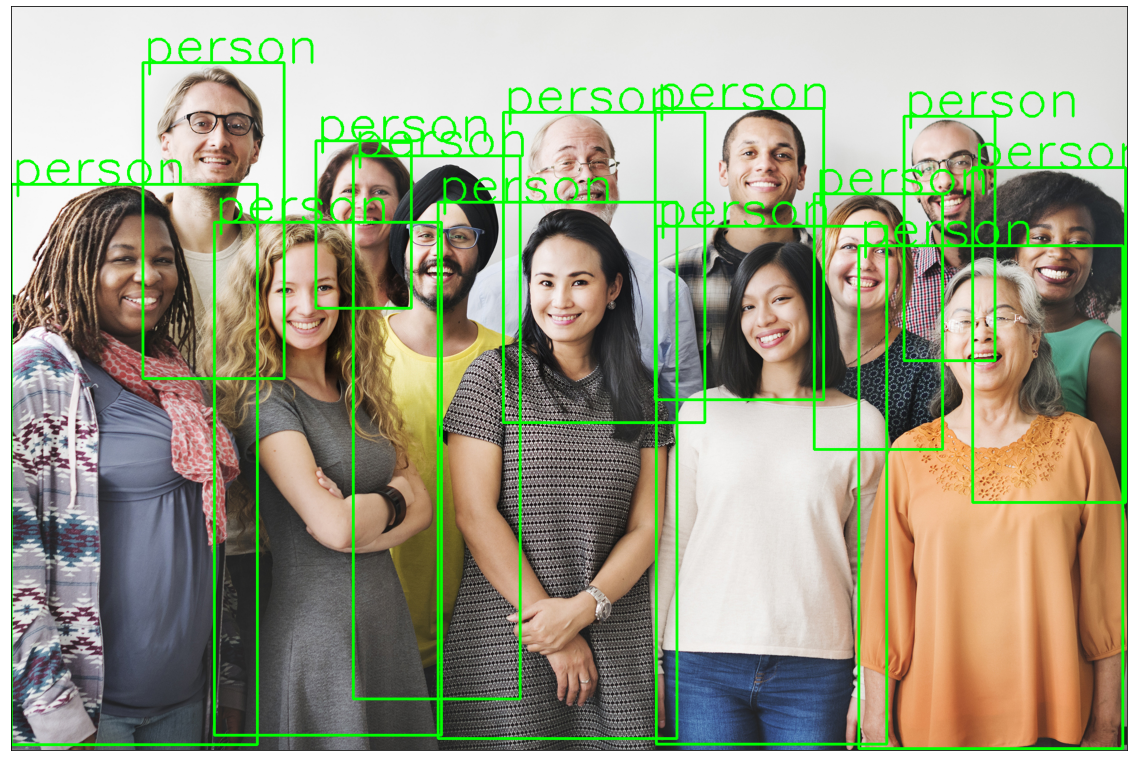

In [ ]:
object_detection_api("/content/people.jpg", threshold=0.8)

--2021-01-20 13:50:51--  https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg
Resolving hips.hearstapps.com (hips.hearstapps.com)... 151.101.0.155, 151.101.64.155, 151.101.128.155, ...
Connecting to hips.hearstapps.com (hips.hearstapps.com)|151.101.0.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2178423 (2.1M) [image/jpeg]
Saving to: ‘car.jpg’

car.jpg             100%[===================>]   2.08M  --.-KB/s    in 0.1s    

2021-01-20 13:50:51 (16.0 MB/s) - ‘car.jpg’ saved [2178423/2178423]



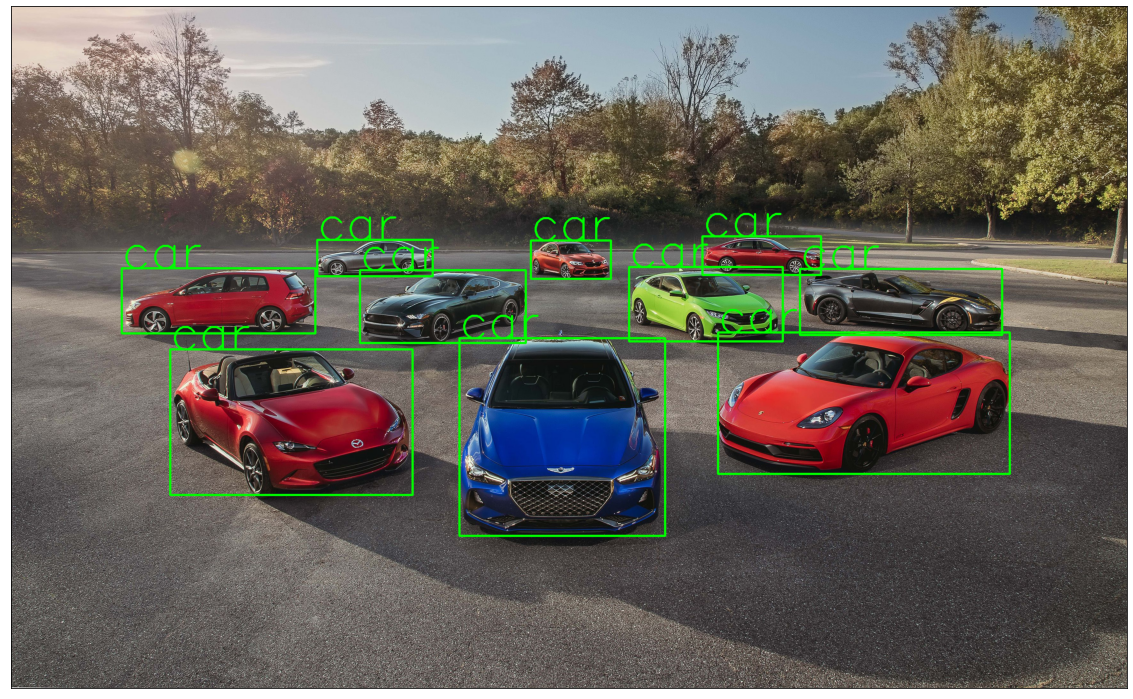

In [ ]:
!wget https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/10best-cars-group-cropped-1542126037.jpg -O car.jpg

object_detection_api("/content/car.jpg", rect_th=6, text_th=5, text_size=5)

--2021-01-20 13:51:01--  https://cdn.pixabay.com/photo/2013/07/05/01/08/traffic-143391_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.21.183, 104.18.20.183, 2606:4700::6812:15b7, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.21.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 191490 (187K) [image/jpeg]
Saving to: ‘traffic.jpg’

traffic.jpg         100%[===================>] 187.00K  --.-KB/s    in 0.02s   

2021-01-20 13:51:02 (11.6 MB/s) - ‘traffic.jpg’ saved [191490/191490]



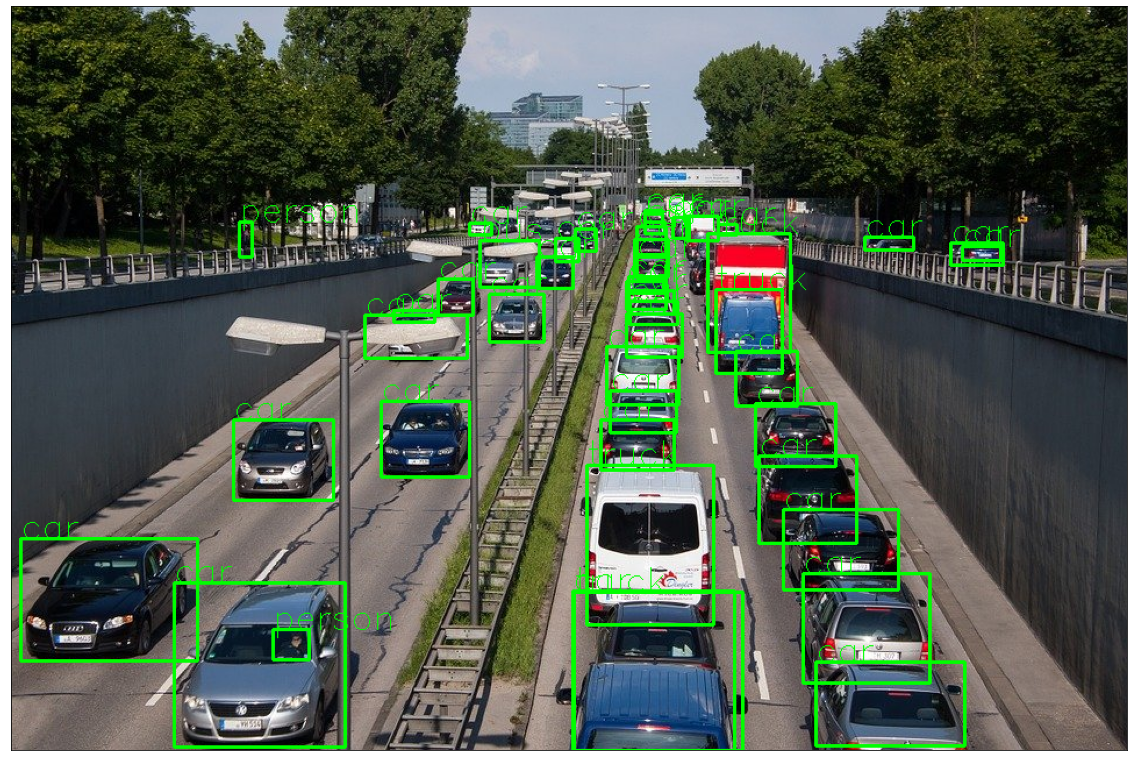

In [ ]:
!wget https://cdn.pixabay.com/photo/2013/07/05/01/08/traffic-143391_960_720.jpg -O traffic.jpg

object_detection_api("/content/traffic.jpg", rect_th=2, text_th=1, text_size=1)


--2021-01-20 14:00:01--  https://static.mothership.sg/1/2018/09/cat-car-roof-pasir-ris.jpg
Resolving static.mothership.sg (static.mothership.sg)... 104.22.35.123, 104.22.34.123, 172.67.21.232, ...
Connecting to static.mothership.sg (static.mothership.sg)|104.22.35.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 148864 (145K) [image/jpeg]
Saving to: ‘cats_bus.jpg’

cats_bus.jpg        100%[===================>] 145.38K  --.-KB/s    in 0.01s   

2021-01-20 14:00:01 (11.9 MB/s) - ‘cats_bus.jpg’ saved [148864/148864]



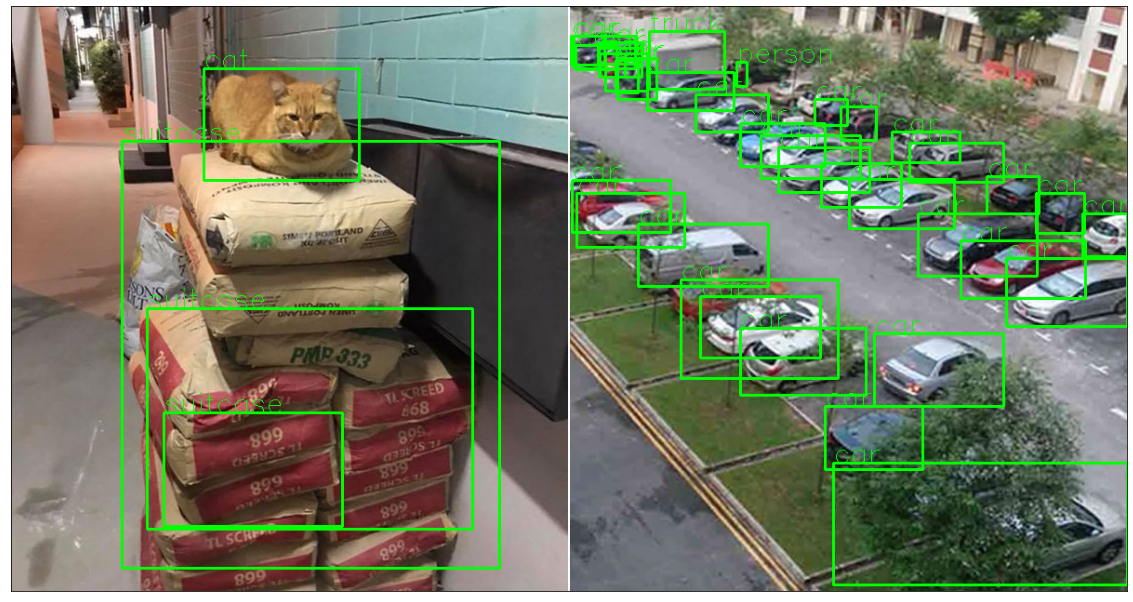

In [ ]:
!wget  https://static.mothership.sg/1/2018/09/cat-car-roof-pasir-ris.jpg -O cats_bus.jpg
object_detection_api("/content/cats_bus.jpg", rect_th=2, text_th=1, text_size=1)